In [707]:
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt

In [708]:
#Base de otimização de rotas

otimizacao_rotas = pd.read_excel("Otimização de rotas.xlsx",sheet_name='Trajeto Geral (Equ x Base Faz)', skiprows=6).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

In [709]:
#Capacidade por equipe
capacidade_equipe = pd.read_excel('Cadastro equipes e demandas.xlsx', sheet_name='Capacidade por equipe')

In [710]:
#Base de demandas

demanda = pd.read_excel('Cadastro equipes e demandas.xlsx', sheet_name='Demanda por fazenda', dtype={'ID Fazenda': 'object', 'Mês de Demanda': 'datetime64[ns]'})

In [711]:
#Função de máscara

def mascara(df, coluna,n_digitos):
    df[coluna] = df[coluna].astype(str)
    df[coluna] = str("000") + df[coluna]
    df[coluna] = df[coluna].astype(str).str[-n_digitos:] 
    return df

In [712]:
#demanda 
demanda = mascara(demanda,'ID Fazenda', 4)

demanda.head(5)

,ID Fazenda,Fazenda,Área Avaliada,Mês avaliação,Data de Avaliação
0,0001,MAMEDINA,1395.99,2024-04-01,2024-04-08 00:00:00.000
1,0003,UNIÃO,748.94,2024-03-01,2024-03-24 00:00:00.000
2,0004,SÃO LUIZ,196.08,2024-04-01,2024-04-03 00:00:00.000
3,0005,SANTA RITA,164.06,2024-04-01,2024-04-09 00:00:00.000
4,0006,LIMEIRA,820.61,2024-03-01,2024-03-21 04:06:51.429


In [713]:
#Data frame de equipes e siglas
equipes = [ i for  i in otimizacao_rotas['COD'].str[7:].unique()]
equipes_s = [ i for  i in otimizacao_rotas['Equipe'].unique()]


equipes_base = pd.DataFrame(
    { 'Equipe': equipes,
     'Equipe sigla' : equipes_s
    }
)

equipes_base.head(len(equipes))

,Equipe,Equipe sigla
0,Lençóis Paulista,A
1,Duartina,B
2,Garça,C
3,Pirajuí,D
4,Bauru,E
5,Getulina,G
6,Cabrália Paulista,H


In [714]:
#Capacidade da equipe 

capacidade_equipe['Gordura'] = 0.05

capacidade_equipe['Capacidade ajustada'] = (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade']) + capacidade_equipe['Capacidade']

capacidade_equipe['Capacidade minima'] = capacidade_equipe['Capacidade'] - (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade'])


capacidade_equipe = capacidade_equipe.merge(equipes_base, on='Equipe', how='left')

capacidade_equipe.head(6)

,Equipe,Capacidade,Mês Operacional,Gordura,Capacidade ajustada,Capacidade minima,Equipe sigla
0,Lençóis Paulista,7400,2024-04-01,0.05,7770.0,7030.0,A
1,Duartina,7400,2024-04-01,0.05,7770.0,7030.0,B
2,Garça,7400,2024-04-01,0.05,7770.0,7030.0,C
3,Pirajuí,7400,2024-04-01,0.05,7770.0,7030.0,D
4,Bauru,7400,2024-04-01,0.05,7770.0,7030.0,E
5,Getulina,7400,2024-04-01,0.05,7770.0,7030.0,G


In [715]:
#Otimização de rotas

otimizacao_rotas = mascara(otimizacao_rotas,'ID Fazenda',4)

otimizacao_rotas

,Equipe,Cidade origem,ID Fazenda,Projeto,Área,COD,Trajeto (Km)
0,A,Lençóis Paulista,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001
1,B,Duartina,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400
2,C,Garça,0001,MAMEDINA,1772.63,0001 - Garça,110.671138
3,D,Pirajuí,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666
4,E,Bauru,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475
...,...,...,...,...,...,...,...
6617,C,Garça,2417,CAFEZAL,120.82,2417 - Garça,252.471501
6618,D,Pirajuí,2417,CAFEZAL,120.82,2417 - Pirajuí,262.590625
6619,E,Bauru,2417,CAFEZAL,120.82,2417 - Bauru,207.695434
6620,G,Getulina,2417,CAFEZAL,120.82,2417 - Getulina,312.662195


In [716]:
#Construindo otimização de rotas

#trazendo base de demandas
otimizacao_rotas = otimizacao_rotas.merge(demanda[['ID Fazenda','Área Avaliada', 'Mês avaliação']], left_on='ID Fazenda', right_on='ID Fazenda', how='left')

#Ordenando a base
otimizacao_rotas = otimizacao_rotas.sort_values(['ID Fazenda','Trajeto (Km)'],ascending=[True,True])

#Capacidade por equipe
otimizacao_rotas = otimizacao_rotas.merge(capacidade_equipe[['Mês Operacional', 'Capacidade', 'Capacidade ajustada', 'Equipe sigla']],left_on=['Equipe','Mês avaliação'], right_on=['Equipe sigla','Mês Operacional'], how='left')

otimizacao_rotas= otimizacao_rotas.rename({
    'Mês Operacional':'Mês operacional equipe',
    'Mês avaliação': 'Mês demanda'
}, axis=1)


otimizacao_rotas = otimizacao_rotas.drop(['Equipe sigla','Cidade origem'],axis=1)

#Filtro apenas para testes
#otimizacao_rotas = otimizacao_rotas[otimizacao_rotas['ID Fazenda'] == '0001']

otimizacao_rotas = otimizacao_rotas[pd.notna(otimizacao_rotas['Mês operacional equipe'])]



In [717]:
# Definindo indice da equipe

# otimizacao_rotas['ID Fazenda Shift'] = otimizacao_rotas['ID Fazenda'].shift(-1)

# def equipe_proxima(row):
#     ordem = 0
#     if row['ID Fazenda'] == row['ID Fazenda Shift']:
#          ordem +=1
#     else:
#          ordem = 0


# otimizacao_rotas['indice equipe'] = otimizacao_rotas.apply(equipe_proxima, axis=1)



In [718]:
#Resetando o índice para utilizá-lo no i.loc
otimizacao_rotas.reset_index(drop=True, inplace=True)

otimizacao_rotas['Equipe mais próxima'] = 0
ordem = 0

for i in range(1, len(otimizacao_rotas)):
    if otimizacao_rotas.loc[i, 'ID Fazenda'] == otimizacao_rotas.loc[i-1, 'ID Fazenda']:
        ordem += 1
    else:
        ordem = 0
    otimizacao_rotas.loc[i, 'Equipe mais próxima'] = ordem

In [719]:
#Criar um print para ir rodando quais são as equipes mais próximas e qual a distância. Pode ser um dicionário. mas deve ser printado para mostrar a funcionalidade da ferramenta

In [720]:
#Criar uma lógica para criar um dicionário que vai aumentando a demanda conforme é atribuído fazendas para ela de acordo com a coluna equipe mais próxima

#A fazenda deve sempre ser atribuída no momento que ela for mais próxima da equipe, a capacidade só pode ser olhada quando a equipe mais próxima for maior que zero

#Tabelinha de demanda da equipe com a demanda mês atual dela


In [721]:
# Exemplo de DataFrames
data1 = {'ID': [1, 2, 3, 4], 'Valor': [10, 20, 30, 40]}
data2 = {'ID': [1, 2, 3, 4], 'Acumulado': [0, 0, 0, 0]}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Loop para iterar sobre as linhas de df1 e acumular valores em df2
for i, row in df1.iterrows():
    df2.loc[i, 'Acumulado'] += row['Valor']

print(df2)

   ID  Acumulado
0   1         10
1   2         20
2   3         30
3   4         40


In [722]:
otimizacao_rotas = otimizacao_rotas[otimizacao_rotas['ID Fazenda'] == '0001'] 

otimizacao_rotas

,Equipe,ID Fazenda,Projeto,Área,COD,Trajeto (Km),Área Avaliada,Mês demanda,Mês operacional equipe,Capacidade,Capacidade ajustada,Equipe mais próxima
0,A,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,0
1,E,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,1
2,H,0001,MAMEDINA,1772.63,0001 - Cabrália Paulista,69.073404,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,2
3,B,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,3
4,D,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,4
5,C,0001,MAMEDINA,1772.63,0001 - Garça,110.671138,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,5
6,G,0001,MAMEDINA,1772.63,0001 - Getulina,160.227397,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,6


In [723]:
#Plano A

#Sempre vai me trazer qual é a equipe mais próxima

def definir_equipe(row):
    if (row['Equipe mais próxima'] == 0 ) & (row['Mês demanda'] == row['Mês operacional equipe']):
        return row['Equipe']
    else:
        return np.nan

otimizacao_rotas['Plano A'] = otimizacao_rotas.apply(definir_equipe,axis=1)


In [724]:
capacidade_equipe

,Equipe,Capacidade,Mês Operacional,Gordura,Capacidade ajustada,Capacidade minima,Equipe sigla
0,Lençóis Paulista,7400,2024-04-01,0.05,7770.0,7030.0,A
1,Duartina,7400,2024-04-01,0.05,7770.0,7030.0,B
2,Garça,7400,2024-04-01,0.05,7770.0,7030.0,C
3,Pirajuí,7400,2024-04-01,0.05,7770.0,7030.0,D
4,Bauru,7400,2024-04-01,0.05,7770.0,7030.0,E
5,Getulina,7400,2024-04-01,0.05,7770.0,7030.0,G
6,Cabrália Paulista,7400,2024-04-01,0.05,7770.0,7030.0,H
7,Lençóis Paulista,7400,2024-03-01,0.05,7770.0,7030.0,A
8,Duartina,7400,2024-03-01,0.05,7770.0,7030.0,B
9,Garça,7400,2024-03-01,0.05,7770.0,7030.0,C


In [725]:
#Agora com o plano A definido, vamos criar uma base para ir somando a demanda da equipe por programação

#Ter a demanda máxima e mínima para cada equipe ou se não pode cair em um loop infinito


carteira_equipe = {}


def adiciona_equipe(informacoes_equipe ,dicionario, demanda_inicial):
    for k,v  in informacoes_equipe.iterrows():
        dicionario[v['Equipe sigla']]  = {
                                'demanda':demanda_inicial,
                                'capicade maxima': v['Capacidade ajustada'],
                                'capacidade minima': v['Capacidade minima']
                              
                                }




adiciona_equipe(capacidade_equipe,carteira_equipe,0)


carteira_equipe


{'A': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'B': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'C': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'D': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'E': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'G': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0},
 'H': {'demanda': 0, 'capicade maxima': 7770.0, 'capacidade minima': 7030.0}}

In [726]:
capacidade_equipe

,Equipe,Capacidade,Mês Operacional,Gordura,Capacidade ajustada,Capacidade minima,Equipe sigla
0,Lençóis Paulista,7400,2024-04-01,0.05,7770.0,7030.0,A
1,Duartina,7400,2024-04-01,0.05,7770.0,7030.0,B
2,Garça,7400,2024-04-01,0.05,7770.0,7030.0,C
3,Pirajuí,7400,2024-04-01,0.05,7770.0,7030.0,D
4,Bauru,7400,2024-04-01,0.05,7770.0,7030.0,E
5,Getulina,7400,2024-04-01,0.05,7770.0,7030.0,G
6,Cabrália Paulista,7400,2024-04-01,0.05,7770.0,7030.0,H
7,Lençóis Paulista,7400,2024-03-01,0.05,7770.0,7030.0,A
8,Duartina,7400,2024-03-01,0.05,7770.0,7030.0,B
9,Garça,7400,2024-03-01,0.05,7770.0,7030.0,C


In [737]:
#Agora com o plano A definido, vamos criar uma base para ir somando a demanda da equipe por programação

#Ter a demanda máxima e mínima para cada equipe ou se não pode cair em um loop infinito


carteira_equipe = {}


def adiciona_equipe(informacoes_equipe, dicionario, demanda_inicial):
    for _, v in informacoes_equipe.iterrows():
        dicionario[v['Equipe sigla'] + ' ' + str(v['Mês Operacional'].month)] = {
            'equipe': v['Equipe sigla'],
            'mes': pd.to_datetime(v['Mês Operacional']),
            'demanda': demanda_inicial,
            'capacidade maxima': v['Capacidade ajustada'],
            'capacidade minima': v['Capacidade minima']
        }

# Adicionar equipes ao dicionário
adiciona_equipe(capacidade_equipe, carteira_equipe, 0)


In [757]:
carteira_equipe['A 4']['capacidade maxima']

7770.0

In [740]:
#Data frma do dicionário e seguindo a orientação por index

carteira_df = pd.DataFrame.from_dict(carteira_equipe, orient='index')

carteira_df

,equipe,mes,demanda,capacidade maxima,capacidade minima
A 4,A,2024-04-01,0,7770.0,7030.0
B 4,B,2024-04-01,0,7770.0,7030.0
C 4,C,2024-04-01,0,7770.0,7030.0
D 4,D,2024-04-01,0,7770.0,7030.0
E 4,E,2024-04-01,0,7770.0,7030.0
G 4,G,2024-04-01,0,7770.0,7030.0
H 4,H,2024-04-01,0,7770.0,7030.0
A 3,A,2024-03-01,0,7770.0,7030.0
B 3,B,2024-03-01,0,7770.0,7030.0
C 3,C,2024-03-01,0,7770.0,7030.0


In [590]:
otimizacao_rotas

,Equipe,ID Fazenda,Projeto,Área,COD,Trajeto (Km),Área Avaliada,Mês demanda,Mês operacional equipe,Capacidade,Capacidade ajustada,Equipe mais próxima,Plano A
0,A,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,0,A
1,E,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,1,NaN
2,H,0001,MAMEDINA,1772.63,0001 - Cabrália Paulista,69.073404,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,2,NaN
3,B,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,3,NaN
4,D,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,B,2411,PINDORAMA II - GLEBA C,860.08,2411 - Duartina,81.725020,18.66,2024-04-01,2024-04-01,7400.0,7770.0,2,NaN
2754,A,2411,PINDORAMA II - GLEBA C,860.08,2411 - Lençóis Paulista,82.414277,18.66,2024-04-01,2024-04-01,7400.0,7770.0,3,NaN
2755,H,2411,PINDORAMA II - GLEBA C,860.08,2411 - Cabrália Paulista,85.177795,18.66,2024-04-01,2024-04-01,7400.0,7770.0,4,NaN
2756,C,2411,PINDORAMA II - GLEBA C,860.08,2411 - Garça,97.382755,18.66,2024-04-01,2024-04-01,7400.0,7770.0,5,NaN


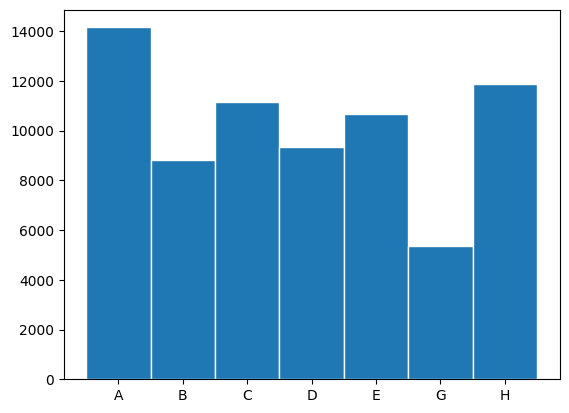

71352.95999999999


In [600]:
filtro_data = pd.Timestamp('2024-04-01')

distribuicao = otimizacao_rotas[(otimizacao_rotas['Equipe mais próxima'] == 0 ) & (otimizacao_rotas['Mês operacional equipe'] == filtro_data) ].groupby('Equipe')['Área Avaliada'].sum().reset_index()

fig,ax = plt.subplots()

x = distribuicao['Equipe']

y = distribuicao['Área Avaliada']

ax.bar(x,y, width=1, edgecolor = 'white')


plt.show()

print(distribuicao['Área Avaliada'].sum())


